In [1]:
!pip install python-crfsuite
!pip install nltk

  Using cached python_crfsuite-0.9.7-cp39-cp39-linux_x86_64.whl
  Using cached nltk-3.6.5-py3-none-any.whl (1.5 MB)
  Using cached regex-2021.11.10-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (763 kB)


In [2]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
  
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

# Solution 1


In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 
from sklearn.model_selection import train_test_split

training_data, test_data = train_test_split(raw_training_data, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data[0]}")
print(f"No. of testing examples: {test_data[0]}")

No. of training examples: [('which', 'O'), ('action', 'B-Genre'), ('comedy', 'I-Genre'), ('released', 'O'), ('in', 'O'), ('2010', 'B-Year'), ('stars', 'O'), ('kristen', 'B-Actor'), ('wiig', 'I-Actor'), ('maya', 'I-Actor'), ('rudolph', 'I-Actor'), ('and', 'O'), ('val', 'B-Actor'), ('kilmer', 'I-Actor')]
No. of testing examples: [('the', 'O'), ('referee', 'O'), ('in', 'O'), ('the', 'O'), ('final', 'O'), ('match', 'O'), ('in', 'O'), ('this', 'O'), ('1984', 'B-Year'), ('martial', 'B-Genre'), ('arts', 'I-Genre'), ('movie', 'O'), ('starring', 'O'), ('ralph', 'B-Actor'), ('macchio', 'I-Actor'), ('is', 'O'), ('pat', 'B-Actor'), ('e', 'I-Actor'), ('johnson', 'I-Actor'), ('a', 'O'), ('martial', 'O'), ('arts', 'O'), ('expert', 'O'), ('and', 'O'), ('former', 'O'), ('student', 'O'), ('of', 'O'), ('chuck', 'B-Actor'), ('norris', 'I-Actor')]


In [5]:
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
print(len(training_data), "instances")
print(sum([len(sent) for sent in training_data]), "words")

6252 instances
127158 words


In [7]:
def preProcess(example):
    
    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [8]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
   
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [9]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [10]:
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [11]:
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [12]:
 # load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
31665 words


In [13]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [14]:
print( classification_report(y_test, preds,zero_division=0))
report = classification_report(y_test, preds, output_dict=True,zero_division=0) # dictionary is created for question 2 
if 'accuracy' in report.keys():
      del(report['accuracy'])
print(precision_recall_fscore_support(y_test, preds, average='macro',zero_division=0))  # print out accurate macro score


                  precision    recall  f1-score   support

         B-Actor       0.88      0.87      0.88       997
         B-Award       0.85      0.56      0.68        62
B-Character_Name       0.73      0.17      0.28       222
      B-Director       0.85      0.68      0.75       380
         B-Genre       0.83      0.74      0.78       693
       B-Opinion       0.56      0.25      0.35       190
        B-Origin       0.49      0.38      0.43       142
          B-Plot       0.49      0.47      0.48      1297
         B-Quote       0.36      0.21      0.27        19
  B-Relationship       0.78      0.46      0.58       124
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.95      0.97      0.96       529
         I-Actor       0.87      0.88      0.87      1214
         I-Award       0.77      0.82      0.79       121
I-Character_Name       0.77      0.24      0.37       165
      I-Director       0.85      0.68      0.76       338
         I-Ge

In [15]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    print(len(y_test))
    print(len(preds))
    print(len(labels))
    cm = confusion_matrix(y_test, preds, labels = list(set(y_test)))
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

31665
31665
25


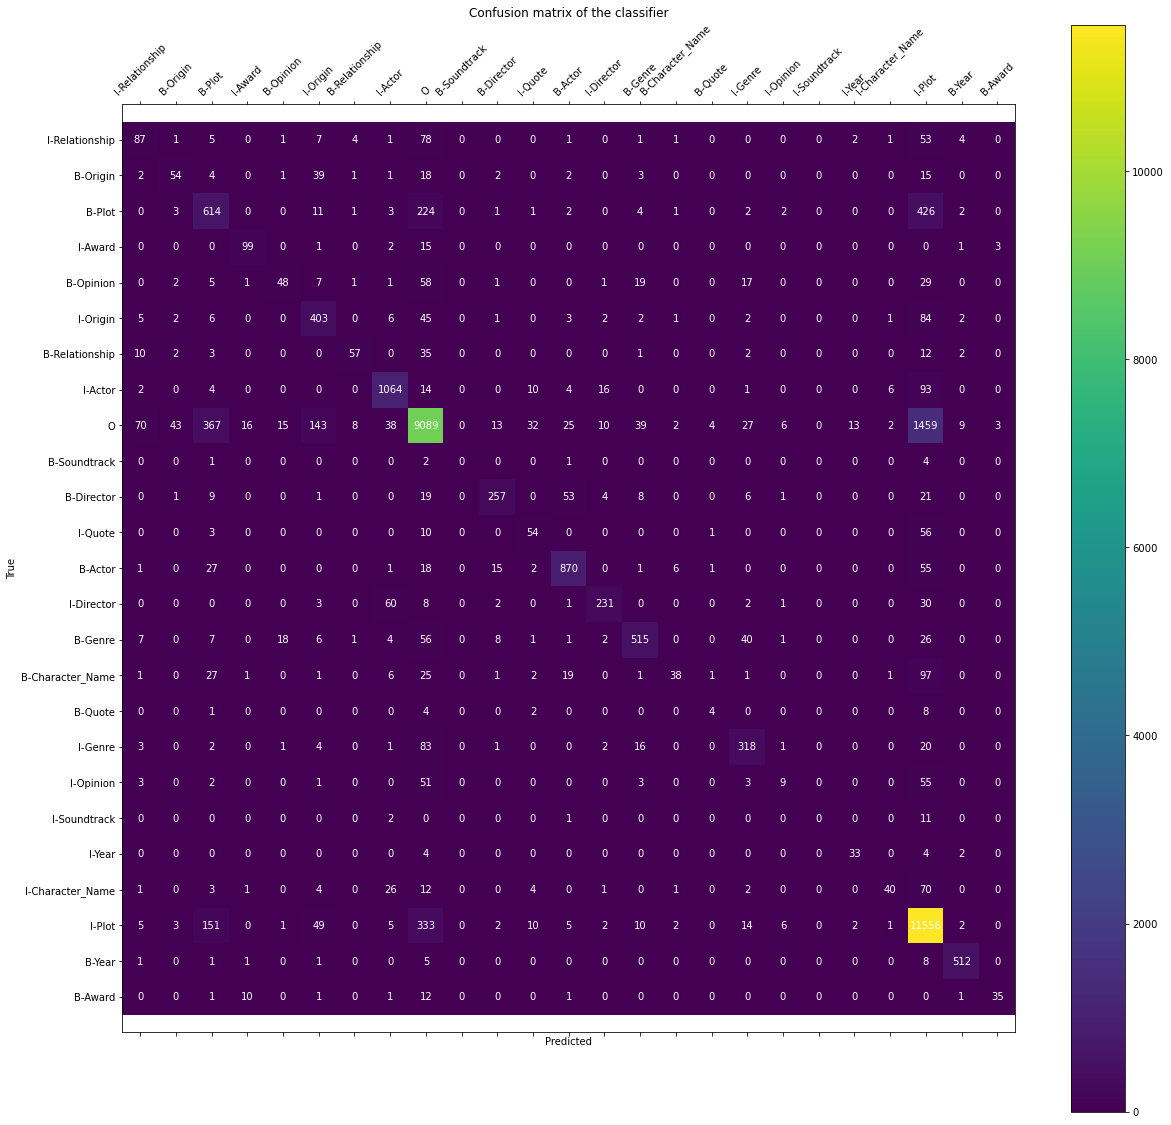

In [16]:
confusion_matrix_heatmap(y_test, preds)

# SOLUTION 2

In [19]:
tags=sorted(report,key=lambda x:(report[x]['precision']))
five_classes= tags[0:5]
print(five_classes)

['B-Soundtrack', 'I-Soundtrack', 'I-Opinion', 'B-Quote', 'I-Relationship']


In [21]:
false_pos = set()

for sentence in test_data:
    sentence_preds= [x[1] for x in ct.tag([s[0] for s in sentence])]
    sentence_true= [s[1] for s in sentence]
    for i in range(len(sentence_preds)):
        if (sentence_preds[i] !=sentence_true[i] and sentence_preds[i] in five_classes):
            sent = [s[0] for s in sentence]
            print("{ Word-->",sent[i],"predicted-->",sentence_preds[i],"true-->",sentence_true[i],"index of word--->",i+1)
            sent = " ".join(sent)
            print(sent,"}")
            false_pos.add(sent)

print("total false positive ---> ",len(false_pos))            
    

{ Word--> god predicted--> B-Quote true--> I-Quote index of word---> 9
what classic movie had the famous line as god is my witness i ll never be hungry again }
{ Word--> movie predicted--> I-Relationship true--> O index of word---> 5
what is the first movie in a trilogy starring keanu reeves directed by the wachowski brothers }
{ Word--> in predicted--> I-Relationship true--> O index of word---> 6
what is the first movie in a trilogy starring keanu reeves directed by the wachowski brothers }
{ Word--> a predicted--> I-Relationship true--> O index of word---> 7
what is the first movie in a trilogy starring keanu reeves directed by the wachowski brothers }
{ Word--> trilogy predicted--> I-Relationship true--> B-Relationship index of word---> 8
what is the first movie in a trilogy starring keanu reeves directed by the wachowski brothers }
{ Word--> westley predicted--> B-Quote true--> B-Character_Name index of word---> 7
this movie stars cary elwes as westley or could it be the dread pira

# SOLUTION 3

In [22]:
tags=sorted(report,key=lambda x:(report[x]['recall']))
five_classes= tags[0:5]
print(five_classes)

['B-Soundtrack', 'I-Soundtrack', 'I-Opinion', 'B-Character_Name', 'B-Quote']


In [24]:
false_neg = set()

for sentence in test_data:
    sentence_preds= [x[1] for x in ct.tag([s[0] for s in sentence])]
    sentence_true= [s[1] for s in sentence]
    for i in range(len(sentence_preds)):
        if (sentence_preds[i] !=sentence_true[i] and sentence_preds[i] not in five_classes):
            sent = [s[0] for s in sentence]
            print("{ Word-->",sent[i],"predicted-->",sentence_preds[i],"true-->",sentence_true[i],"index of word--->",i+1)
            sent = " ".join(sent)
            print(sent,"}") 
            false_neg.add(sent)
print("total false negitive --->",len(false_neg))            
            

{ Word--> pat predicted--> B-Plot true--> B-Actor index of word---> 17
the referee in the final match in this 1984 martial arts movie starring ralph macchio is pat e johnson a martial arts expert and former student of chuck norris }
{ Word--> e predicted--> I-Plot true--> I-Actor index of word---> 18
the referee in the final match in this 1984 martial arts movie starring ralph macchio is pat e johnson a martial arts expert and former student of chuck norris }
{ Word--> johnson predicted--> I-Plot true--> I-Actor index of word---> 19
the referee in the final match in this 1984 martial arts movie starring ralph macchio is pat e johnson a martial arts expert and former student of chuck norris }
{ Word--> a predicted--> I-Plot true--> O index of word---> 20
the referee in the final match in this 1984 martial arts movie starring ralph macchio is pat e johnson a martial arts expert and former student of chuck norris }
{ Word--> martial predicted--> I-Plot true--> O index of word---> 21
the r

# SOLUTION 4

In [25]:
from nltk.tokenize import word_tokenize 
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
def posTagPreProcess(example):
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    tokens = []
    for i in example:
           tagger = list(i) 
           tagger[0] = word_tokenize(i[0])
           try:
              [(a,b,)] = posttagger.tag(tagger[0])
           except ValueError:
              pass
           tagger[0] = a + '*' + b 
           i = tuple(tagger) 
           tokens.append(i)
    preprocessed_example = tokens  
    return preprocessed_example

In [27]:
_pattern = re.compile(r"\d")  

def get_posFeatures(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    
    # Split the special character
    token_split_word = token.split('*') #split the word with special character and get the word & POS tag
    token = token_split_word[0] # store the word in token
        
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + token_split_word[1]) # add POS tagging
#     print(feature_list)
    return feature_list

In [28]:
data=[posTagPreProcess(example) for example in training_data]


In [29]:
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_posFeatures)  # initialize tagger with get_features function

print("training tagger...")
ct.train(data, TAGGER_PATH)
print("done")

training tagger...
done


In [30]:
pre_test_data=[posTagPreProcess(example) for example in test_data]

In [31]:
print("testing tagger...")
predict = []
true = []
for sent in pre_test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    predict.extend(sent_preds)
    true.extend(sent_true)
print("done")

testing tagger...
done


In [32]:
print(classification_report(true, predict))

                  precision    recall  f1-score   support

         B-Actor       0.86      0.85      0.86       997
         B-Award       0.83      0.55      0.66        62
B-Character_Name       0.88      0.13      0.22       222
      B-Director       0.88      0.62      0.72       380
         B-Genre       0.83      0.73      0.78       693
       B-Opinion       0.52      0.23      0.32       190
        B-Origin       0.55      0.42      0.48       142
          B-Plot       0.49      0.46      0.48      1297
         B-Quote       0.44      0.21      0.29        19
  B-Relationship       0.76      0.42      0.54       124
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.95      0.97      0.96       529
         I-Actor       0.85      0.85      0.85      1214
         I-Award       0.75      0.78      0.76       121
I-Character_Name       0.88      0.21      0.34       165
      I-Director       0.85      0.64      0.73       338
         I-Ge

# SOLUTION 5

In [33]:
def get_add_feature(tokens, idx):
  
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Split the special character
    token_split = token.split('*') #split the word with special character and get the word & POS tag        
    word = token_split[0]
    pos_tag=token_split[1]
    
    #Word and Pos_stag
    feature_list.append("WORD_" + word)# Append the word to feature set
    feature_list.append("POS_" + pos_tag) # Append POS tagging to feature set
    
    # Capitalization
    if word[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, word) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in word):
        feature_list.append("PUNCTUATION")
   
    
    # Suffix up to length 3
    if len(word) > 1:
        feature_list.append("SUF_" + word[-1:])
    if len(word) > 2:
        feature_list.append("SUF_" + word[-2:])
    if len(word) > 3:
        feature_list.append("SUF_" + word[-3:])
    # prefix up to length 3
    if len(word) > 1:
        feature_list.append("PREF_" + word[:1])
    if len(word) > 2:
        feature_list.append("PREF_" + word[:2])
    if len(word) > 3:
        feature_list.append("PREF_" + word[:3])
    
    # Hyphen
    if re.search("-", word):
        feature_list.append("HYPHEN")
        
    # is_first
    if (idx==0):
        feature_list.append("FIRST")
        
    # is_last
    if (idx==(len(tokens)-1)):
        feature_list.append("LAST")
        
    # prev_word and prev_tag
    if (idx!=0):
        prev=tokens[idx-1]
        token_split_prev = prev.split('*')
        feature_list.append("PREV_" + token_split_prev[0])    
        feature_list.append("PREV_POS_" + token_split_prev[1])    
      
    # next_word and next_tag
    if (idx<(len(tokens)-1)):
        nextt=tokens[idx+1]
        token_split_next = nextt.split('*')
        feature_list.append("NEXT_" + token_split_next[0])    
        feature_list.append("NEXT_POS_" + token_split_next[1]) 
    
    #print(feature_list)
    return feature_list

In [34]:
raw_train_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 
raw_test_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [35]:
data_raw_train_data=[posTagPreProcess(example) for example in raw_train_data]
data_raw_test_data=[posTagPreProcess(example) for example in raw_test_data]


In [36]:
TAGGER_PATH = "crf_nlu.tagger"  
ct = CRFTagger(feature_func=get_add_feature, training_opt={"feature.minfreq":2,"c1":0.1,"c2":0.5})  #adding min doc freq

print("training tagger...")
ct.train(data_raw_train_data, TAGGER_PATH)
print("done")

training tagger...
done


In [37]:
print("testing tagger...")
predict = []
true = []
for sent in data_raw_test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    predict.extend(sent_preds)
    true.extend(sent_true)
print("done")

testing tagger...
done


In [38]:
print(classification_report(true, predict))

                  precision    recall  f1-score   support

         B-Actor       0.98      0.98      0.98      5010
         B-Award       0.84      0.77      0.81       309
B-Character_Name       0.92      0.70      0.80      1025
      B-Director       0.91      0.93      0.92      1787
         B-Genre       0.90      0.85      0.87      3384
       B-Opinion       0.64      0.58      0.61       810
        B-Origin       0.69      0.59      0.64       779
          B-Plot       0.68      0.64      0.66      6468
         B-Quote       0.95      0.78      0.86       126
  B-Relationship       0.79      0.61      0.69       580
    B-Soundtrack       0.87      0.54      0.67        50
          B-Year       0.98      0.99      0.98      2702
         I-Actor       0.98      0.98      0.98      6121
         I-Award       0.86      0.89      0.88       719
I-Character_Name       0.91      0.75      0.82       760
      I-Director       0.95      0.95      0.95      1653
         I-Ge